# DBTL 7 data analysis

This notebook analyzes OD340 data from DBTL cycle 7 of a flaviolin producing P. putida.

## Inputs and outputs

#### Required file to run this notebook:
   - edd slug


#### File generated by running this notebook:
   
 
    
The files are stored in the user defined directory.

## Setup

Importing needed libraries:

In [9]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.metrics import r2_score

import edd_utils as eddu

In [10]:
from art.core import *
# import art.plot as plot

### User parameters

In [11]:
CYCLE = 3.1

user_params = {
    'output_file_path': f'../flaviolin data/DBTL{CYCLE}', # Folder for output files,
    'bounds_file': f'../flaviolin data/Putida_media_bounds_extended.csv',
    'study_slug': 'combinatorial-media-for-flaviolin-repeats-dbt-59a2',
    'edd_server': 'edd.jbei.org',
    'username': 'azournas',
    } 

In [12]:
study_slug = user_params['study_slug']
edd_server = user_params['edd_server']
username = user_params['username']

## Load the study

In [13]:
try:
  session = eddu.login(edd_server=edd_server, user=username)
except:
  print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
  print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for azournas:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [14]:
df: pd.DataFrame
    
try:
    df = eddu.export_study(session, study_slug, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    try:
        df = pd.read_csv(user_params['study_file'])
    except:
        print(f'ERROR! Alternative loading of data from disk failed!')
    else:
        print(f'OK! Alternative loading of data from disk was successful.')


  0%|          | 0/48 [00:00<?, ?it/s]

In [15]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198110,Combinatorial media for flaviolin repeats DBTL...,198111,6c4d2b6f-80c4-40ff-b0c2-d115cfc19be8,C3.1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198159,C3.1_WA1_C1-R1,NaN,OD340,0,NaN,0.5093,48.0
1,198110,Combinatorial media for flaviolin repeats DBTL...,198112,6e59c076-36b6-46be-bb7e-c517352705fb,C3.1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198160,C3.1_WA1_C1-R2,NaN,OD340,0,NaN,0.4785,48.0
2,198110,Combinatorial media for flaviolin repeats DBTL...,198113,e507cff3-1d66-4d40-81b8-fa0f39514aa7,C3.1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198161,C3.1_WA1_C1-R3,NaN,OD340,0,NaN,0.4685,48.0
3,198110,Combinatorial media for flaviolin repeats DBTL...,198114,0d6f9efd-91bf-4111-8941-d3de11049209,C3.1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198162,C3.1_WD1_F1-R1,NaN,OD340,0,NaN,0.4412,48.0
4,198110,Combinatorial media for flaviolin repeats DBTL...,198115,ad9e106b-8f74-43d7-8add-e71c9e379458,C3.1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198163,C3.1_WD1_F1-R2,NaN,OD340,0,NaN,0.4584,48.0


Drop unnecessary columns:

In [16]:
df = df.loc[:,['Line Name','Line Description','Measurement Type','Value']]
df.head()

,Line Name,Line Description,Measurement Type,Value
0,C3.1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.5093
1,C3.1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4785
2,C3.1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4685
3,C3.1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4412
4,C3.1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4584


In [17]:
find_col = lambda x: x['Line Name'][7]

def find_row(row):
    line_name = row['Line Name']
    if line_name[6] == 'A':
        if int(line_name[-1]) == 1:
            return "A"
        elif int(line_name[-1]) == 2:
            return "B"
        else:
            return "C"
    else:
        if int(line_name[-1]) == 1:
            return "D"
        elif int(line_name[-1]) == 2:
            return "E"
        else:
            return "F"


In [18]:
df['Row'] =  df.apply(find_row, axis=1)
df['Column'] =  df.apply(find_col, axis=1)


## Coefficient of variation

In [19]:
# df_red = df.drop(columns=['Column'])
# stats = df_red.groupby(['Measurement Type', 'Line Description']).mean()
# stats.rename(columns={'Value': 'mean'}, inplace=True)
# stats['std'] = df_red.groupby(['Measurement Type', 'Line Description']).std()
# stats['CV[%]'] = 100* stats['std'] / stats['mean']
# stats

In [20]:
# print("Mean coefficient of variation for OD340:")
# np.mean(stats.loc['OD340','CV[%]'])

## Visualization

/tmp/ipykernel_81588/1875209016.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df,


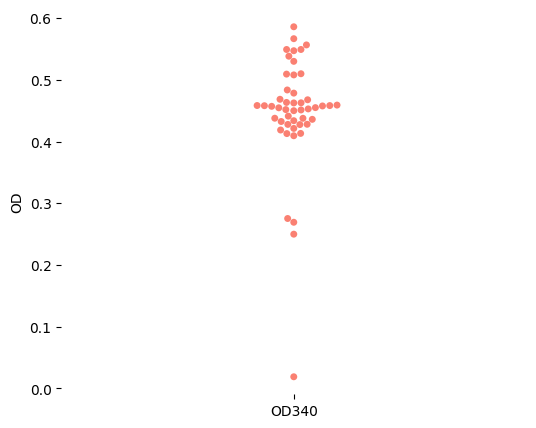

In [21]:
fig, ax = plt.subplots(figsize=(6, 5))
fontsize = 16
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.swarmplot(data=df, 
              linewidth=0,
              x='Measurement Type',
              y='Value',
              palette="dark:salmon_r"
              )
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="OD")

fig.savefig(
    f"{user_params['output_file_path']}/swarm_both.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

Per line:

In [22]:
line_names = []
df_340 = df[df['Measurement Type']=='OD340'].reset_index()
for i in range(int(len(df_340)/3)):
    line_names.append(str(df_340['Line Name'][3*i])[3:-3])
# line_names

/tmp/ipykernel_81588/2548742498.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(line_names, fontsize=8, rotation = 30)


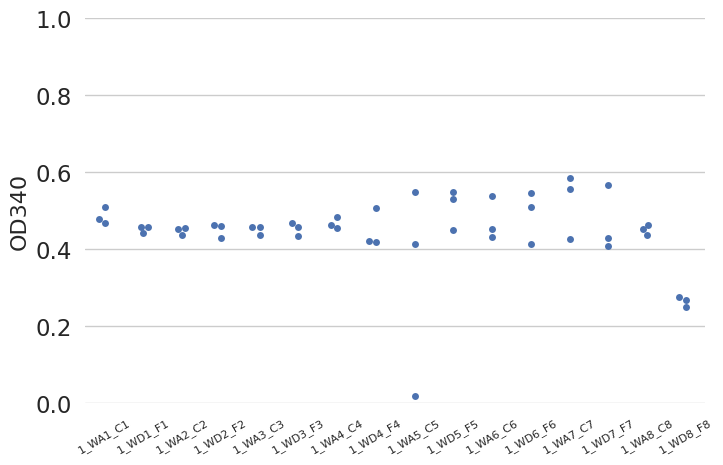

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
fontsize = 14
sns.set_style("whitegrid")
g = sns.swarmplot(data=df, 
              linewidth=0,
              x='Line Description',
              y='Value',
              # hue='Measurement Type',
              # palette="dark:salmon_r",
              )
g.set_xticklabels(line_names, fontsize=8, rotation = 30)
# plt.legend(fontsize=fontsize)
sns.despine(left=True, bottom=True)
ax.set_ylabel("OD340", fontsize=fontsize+2)
ax.set_xlabel(None)
plt.ylim([0, 1.])

fig.savefig(
    f"{user_params['output_file_path']}/swarm_per_design.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Plot OD measurements per well

In [24]:
df[df['Measurement Type']=='OD340']

,Line Name,Line Description,Measurement Type,Value,Row,Column
0,C3.1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.5093,A,1
1,C3.1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4785,B,1
2,C3.1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4685,C,1
3,C3.1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4412,D,1
4,C3.1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4584,E,1
5,C3.1_WD1_F1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4581,F,1
6,C3.1_WA2_C2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4547,A,2
7,C3.1_WA2_C2-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4378,B,2
8,C3.1_WA2_C2-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4529,C,2
9,C3.1_WD2_F2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.4278,D,2


In [25]:
data_od340 = df[df['Measurement Type']=='OD340'].pivot(index = 'Row', columns = 'Column',values = 'Value')

In [26]:
data_od340.head(6)

Column,1,2,3,4,5,6,7,8
Row,,,,,,,,
A,0.5093,0.4547,0.4577,0.4550,0.4129,0.4325,0.4275,0.4518
B,0.4785,0.4378,0.4360,0.4628,0.5492,0.5383,0.5566,0.4377
C,0.4685,0.4529,0.4571,0.4836,0.0188,0.4512,0.5860,0.4634
D,0.4412,0.4278,0.4338,0.5080,0.5300,0.5099,0.4094,0.2499
E,0.4584,0.4591,0.4583,0.4213,0.5492,0.5472,0.5667,0.2753
F,0.4581,0.4626,0.4677,0.4187,0.4500,0.4132,0.4280,0.2692


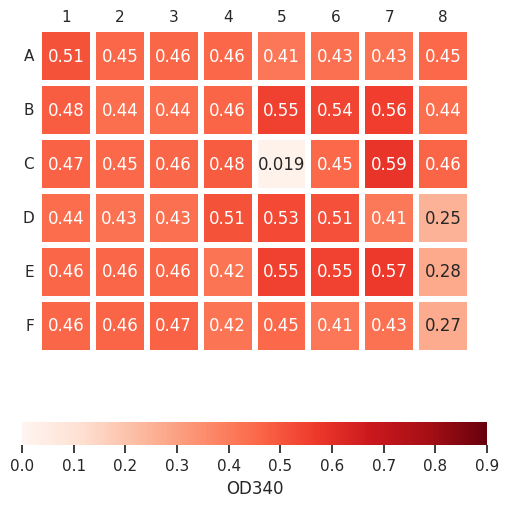

In [41]:
fig = plt.figure(figsize=(10,6))
colormap = sns.color_palette("light:salmon", as_cmap=True)
colormap = "Reds"
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 2.5})
ax = sns.heatmap(data_od340, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap=colormap,
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.6,
                           'label': 'OD340'
                          },
                 annot = True,
                 vmin=0, 
                 vmax=.9
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD340.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Load training data and predictions for recommendations:

In [28]:
user_params['target_designs'] = f"{user_params['output_file_path']}/target_concentrations.csv"

In [29]:
designs_pred = pd.read_csv(user_params['target_designs'], index_col=0).reset_index()
designs_pred.drop(columns='Well', inplace=True)
designs_pred['OD340'] = df[df['Measurement Type']=='OD340']['Value'].values
designs_pred

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label,OD340
0,0.002768,0.295690,11.653411,0.015110,13.297119,0.451467,427.961444,0.000028,0.003668,0.004136,0.012464,0.001219,51.724230,11.457686,explore,0.5093
1,0.002768,0.295690,11.653411,0.015110,13.297119,0.451467,427.961444,0.000028,0.003668,0.004136,0.012464,0.001219,51.724230,11.457686,explore,0.4785
2,0.002768,0.295690,11.653411,0.015110,13.297119,0.451467,427.961444,0.000028,0.003668,0.004136,0.012464,0.001219,51.724230,11.457686,explore,0.4685
3,0.002039,0.306612,11.755484,0.013897,13.529082,0.460584,517.597679,0.000043,0.004579,0.002872,0.012345,0.001194,50.838723,11.538870,explore,0.4412
4,0.002039,0.306612,11.755484,0.013897,13.529082,0.460584,517.597679,0.000043,0.004579,0.002872,0.012345,0.001194,50.838723,11.538870,explore,0.4584
5,0.002039,0.306612,11.755484,0.013897,13.529082,0.460584,517.597679,0.000043,0.004579,0.002872,0.012345,0.001194,50.838723,11.538870,explore,0.4581
6,0.000592,0.231622,11.606334,0.002167,13.520238,0.474551,378.398033,0.000531,0.005309,0.003655,0.009306,0.000410,49.489744,11.707940,explore,0.4547
7,0.000592,0.231622,11.606334,0.002167,13.520238,0.474551,378.398033,0.000531,0.005309,0.003655,0.009306,0.000410,49.489744,11.707940,explore,0.4378
8,0.000592,0.231622,11.606334,0.002167,13.520238,0.474551,378.398033,0.000531,0.005309,0.003655,0.009306,0.000410,49.489744,11.707940,explore,0.4529
9,0.011245,0.383651,11.842890,0.003900,16.703398,0.336866,394.461806,0.000535,0.005284,0.004519,0.007648,0.000159,49.377841,11.710457,explore,0.4278


In [30]:
designs_pred['OD340'] = designs_pred['OD340']*100 

In [31]:
user_params['train_data'] = f'../flaviolin data/DBTL{CYCLE}/train_pred.csv'

In [32]:
train_pred = pd.read_csv(user_params['train_data'], index_col=0)
train_pred

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.019871,0.205718,2.365080,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,20.76,20.972726,8.136166,27.744984,9.019423,train
1,0.019871,0.205718,2.365080,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,21.49,20.972726,8.136166,27.744984,9.019423,train
2,0.019871,0.205718,2.365080,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,21.24,20.972726,8.136166,27.744984,9.019423,train
3,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,19.55,19.420658,8.129622,18.315140,9.807894,train
4,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,18.59,19.420658,8.129622,18.315140,9.807894,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.001315,1.641906,2.762050,0.031787,13.428046,0.516091,251.160635,0.000222,0.000123,0.0001,0.0008,0.0001,58.03,56.971474,8.164936,44.347418,5.661827,train
92,0.001315,1.641906,2.762050,0.031787,13.428046,0.516091,251.160635,0.000222,0.000123,0.0001,0.0008,0.0001,59.15,56.971474,8.164936,44.347418,5.661827,train
93,0.004350,0.316635,1.373984,0.009343,9.152222,0.515452,52.581020,0.000031,0.000325,0.0001,0.0008,0.0001,28.69,28.092365,8.135110,31.661797,9.840196,train
94,0.004350,0.316635,1.373984,0.009343,9.152222,0.515452,52.581020,0.000031,0.000325,0.0001,0.0008,0.0001,28.86,28.092365,8.135110,31.661797,9.840196,train


In [39]:
def predictions_vs_observations(
    designs,
    train,
    errorbars_flag=False,
    xlim=None,
    ylim=None,
):
    
    plt.style.use("seaborn-white")

    fontsize = 20

    fig, ax = plt.subplots(figsize=(7, 7))
    
    obs_all = np.append(train['OD340'], designs['OD340'])
    pred_all = np.append(train['OD340_cv_pred'], designs['OD340_pred'])
    pred_std_all = np.append(train['OD340_cv_std'], designs['OD340_std'])
   
    
    # Plot Scatter Plot
    if errorbars_flag:
        plt.errorbar(
            obs_all,
            pred_all,
            yerr=1.96 * pred_std_all,
            fmt='none',
            ecolor="lightgray",
            elinewidth=1,
            alpha=0.5,
            zorder=0
        )
            
    plt.scatter(
        train['OD340'], 
        train['OD340_cv_pred'], 
        color="gray",
        label='train'
    )

    standard = train[train['Label']=='standard']
    plt.scatter(
        standard['OD340'], 
        standard['OD340_cv_pred'],
        label='standard',
        color="k"
    )
    
    standard_des = designs[designs['Label']=='standard']
    plt.scatter(standard_des['OD340'], standard_des['OD340_pred'], color="k")
    
    exploit_des = designs[designs['Label']=='exploit']
    plt.scatter(
        exploit_des['OD340'], 
        exploit_des['OD340_pred'], 
        color="r",
        label='exploitation'
    )
    
    explore_des = designs[designs['Label']=='explore']
    plt.scatter(
        explore_des['OD340'], 
        explore_des['OD340_pred'], 
        color="orange",
        label='exploration'
    )
    
    r2_train = round(r2_score(train['OD340'], train['OD340_cv_pred']), 2)
    
    r2_all = round(r2_score(obs_all, pred_all), 2)

    ax.set_title(f"$R^2$={r2_train}", fontsize=fontsize)
    
    print(f"$R^2$={r2_all}")
    ax.set_xlabel("Observations", fontsize=fontsize)
    ax.set_ylabel("Cross-validation predictions", fontsize=fontsize)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    if xlim is None:
        ax.set_xlim(lims)
    else:
        ax.set_xlim(xlim)

    if ylim is None:
        ax.set_ylim(lims)
    else:
        ax.set_ylim(ylim)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    
    plt.legend(loc='best', 
               fontsize=fontsize-4)

    plt.tick_params(axis="both", which="major", labelsize=fontsize)
    plt.show()

    fig.savefig(
        user_params['output_file_path']
        + "/predictions_vs_observations.png",
        bbox_inches="tight",
        transparent=False,
        dpi=300,
    )

    plt.close(fig)

$R^2$=0.22


/tmp/ipykernel_81588/2306706340.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


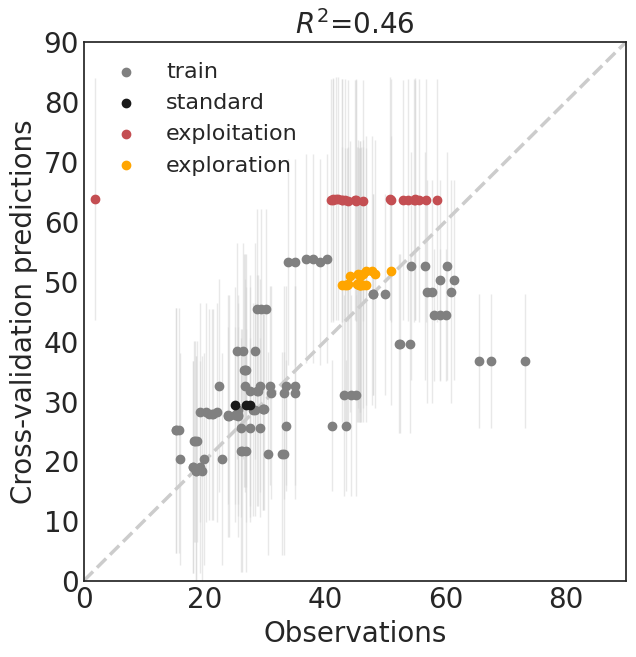

In [40]:
predictions_vs_observations(
    designs=designs_pred,
    train=train_pred,
    errorbars_flag=True,
    xlim=[0., 90],
    ylim=[0., 90],
)

In [38]:
user_params['output_file_path']

'../flaviolin data/DBTL3.1'

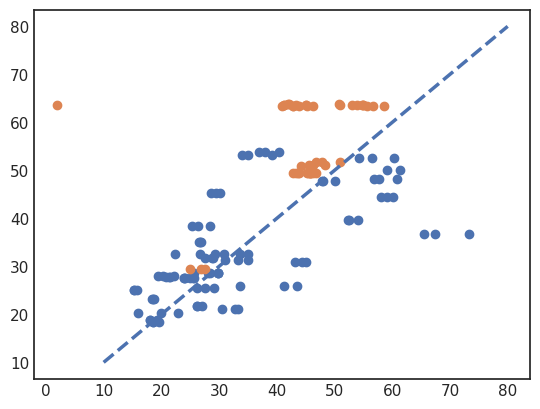

In [35]:
plt.scatter(train_pred['OD340'], train_pred['OD340_cv_pred'])
plt.scatter(designs_pred['OD340'], designs_pred['OD340_pred'])
plt.plot([10, 80], [10, 80], '--')

## Inspect designs

In [69]:
df_all = train_pred.drop(
    columns=['OD340_pred','OD340_std', 'OD340_cv_pred', 'OD340_cv_std']
)
df_all = df_all.append(
    designs_pred.drop(
        columns=['OD340_pred','OD340_std']
    )
).reset_index(drop=True)

/tmp/ipykernel_95/530199538.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(


In [89]:
df_all['OD340_yield'] = df_all['OD340']/df_all['Glucose[mM]']

In [90]:
df_all.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.4422,train,0.022110
1,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.3405,train,0.017025
2,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.3397,train,0.016985
3,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.3602,train,0.018010
4,0.009185,20.0,0.380499,1.156774,0.007971,11.618192,5.030266,50.607910,0.000155,0.000152,0.000029,0.000410,0.000277,0.0,0.2699,train,0.013495


In [91]:
titer_max_ind = df_all['OD340'].nlargest(3).index
df_all.loc[titer_max_ind]

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
320,0.057934,110.380997,0.286511,6.340137,0.093384,14.362711,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.8254,LHS,0.007478
318,0.057934,110.380997,0.286511,6.340137,0.093384,14.362711,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.7352,LHS,0.006661
319,0.057934,110.380997,0.286511,6.340137,0.093384,14.362711,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.7320,LHS,0.006632


In [104]:
yield_max_ind = df_all['OD340_yield'].nlargest(1).index
df_all.loc[yield_max_ind]

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
96,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.7206,train,0.03603


In [113]:
df_all.loc[int((yield_max_ind).values):int((yield_max_ind).values)+2]

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
96,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.7206,train,0.036030
97,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.6227,train,0.031135
98,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.6467,train,0.032335


In [116]:
titer_max = df_all.loc[titer_max_ind]['OD340'].mean()
yield_max = (
    df_all.loc[int((yield_max_ind).values):int((yield_max_ind).values)+2]['OD340_yield']
).mean()

In [117]:
titer_max, yield_max

(0.7642000000000001, 0.03316666666666667)

In [119]:
titer_standard = df_all[df_all['Label']=='standard']['OD340'].mean()
yield_standard = df_all[df_all['Label']=='standard']['OD340_yield'].mean()
titer_standard, yield_standard

(0.2817521739130435, 0.014025777618754504)

In [121]:
improvement = 100*(titer_max/titer_standard-1)
f'Improvement in titer over the control: {improvement:.2f}%'


'Improvement in titer over the control: 171.23%'

In [122]:
improvement = 100*(yield_max/yield_standard-1)
f'Improvement in yield over the control: {improvement:.2f}%'

'Improvement in yield over the control: 136.47%'

In [124]:
df_all = df_all.drop(columns=['Label'])


In [125]:
df_high = df_all[df_all['OD340_yield'] >= 0.015]
df_low = df_all[df_all['OD340_yield'] <= 0.015]

In [126]:
len(df_high), len(df_low)

(219, 118)

In [127]:
df_bounds = pd.read_csv(user_params['bounds_file'])

In [129]:
def designs_pairwise(df_high, df_low, bounds):

    components = df_high.columns[:-2]
    dim = len(components)
#     print(f'dim={dim}')

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X_high = df_high[components].values
    X_low = df_low[components].values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            
            ax.scatter(
                X_high[:, var1],
                X_high[:, var2],
                c="g",
                marker="+",
                s=150*df_high['OD340'],
                lw=1,
                label="high",
            )
            ax.scatter(
                X_low[:, var1],
                X_low[:, var2],
                c="r",
                marker="+",
                s=150*df_low['OD340'],
                lw=1,
                label="low",
            )
            xlims = np.asarray([
                bounds[bounds['Variable']==components[var1]]['Min'],
                bounds[bounds['Variable']==components[var1]]['Max']
            ])
            ylims = np.asarray([
                bounds[bounds['Variable']==components[var2]]['Min'],
                bounds[bounds['Variable']==components[var2]]['Max']
            ])
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
                        
            if var2 == (dim - 1):
                ax.set_xlabel(components[var1])
            if var1 == 0:
                ax.set_ylabel(components[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(
        f'{user_params["output_file_path"]}/designs_pairwise_high.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )

/tmp/ipykernel_95/167804487.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


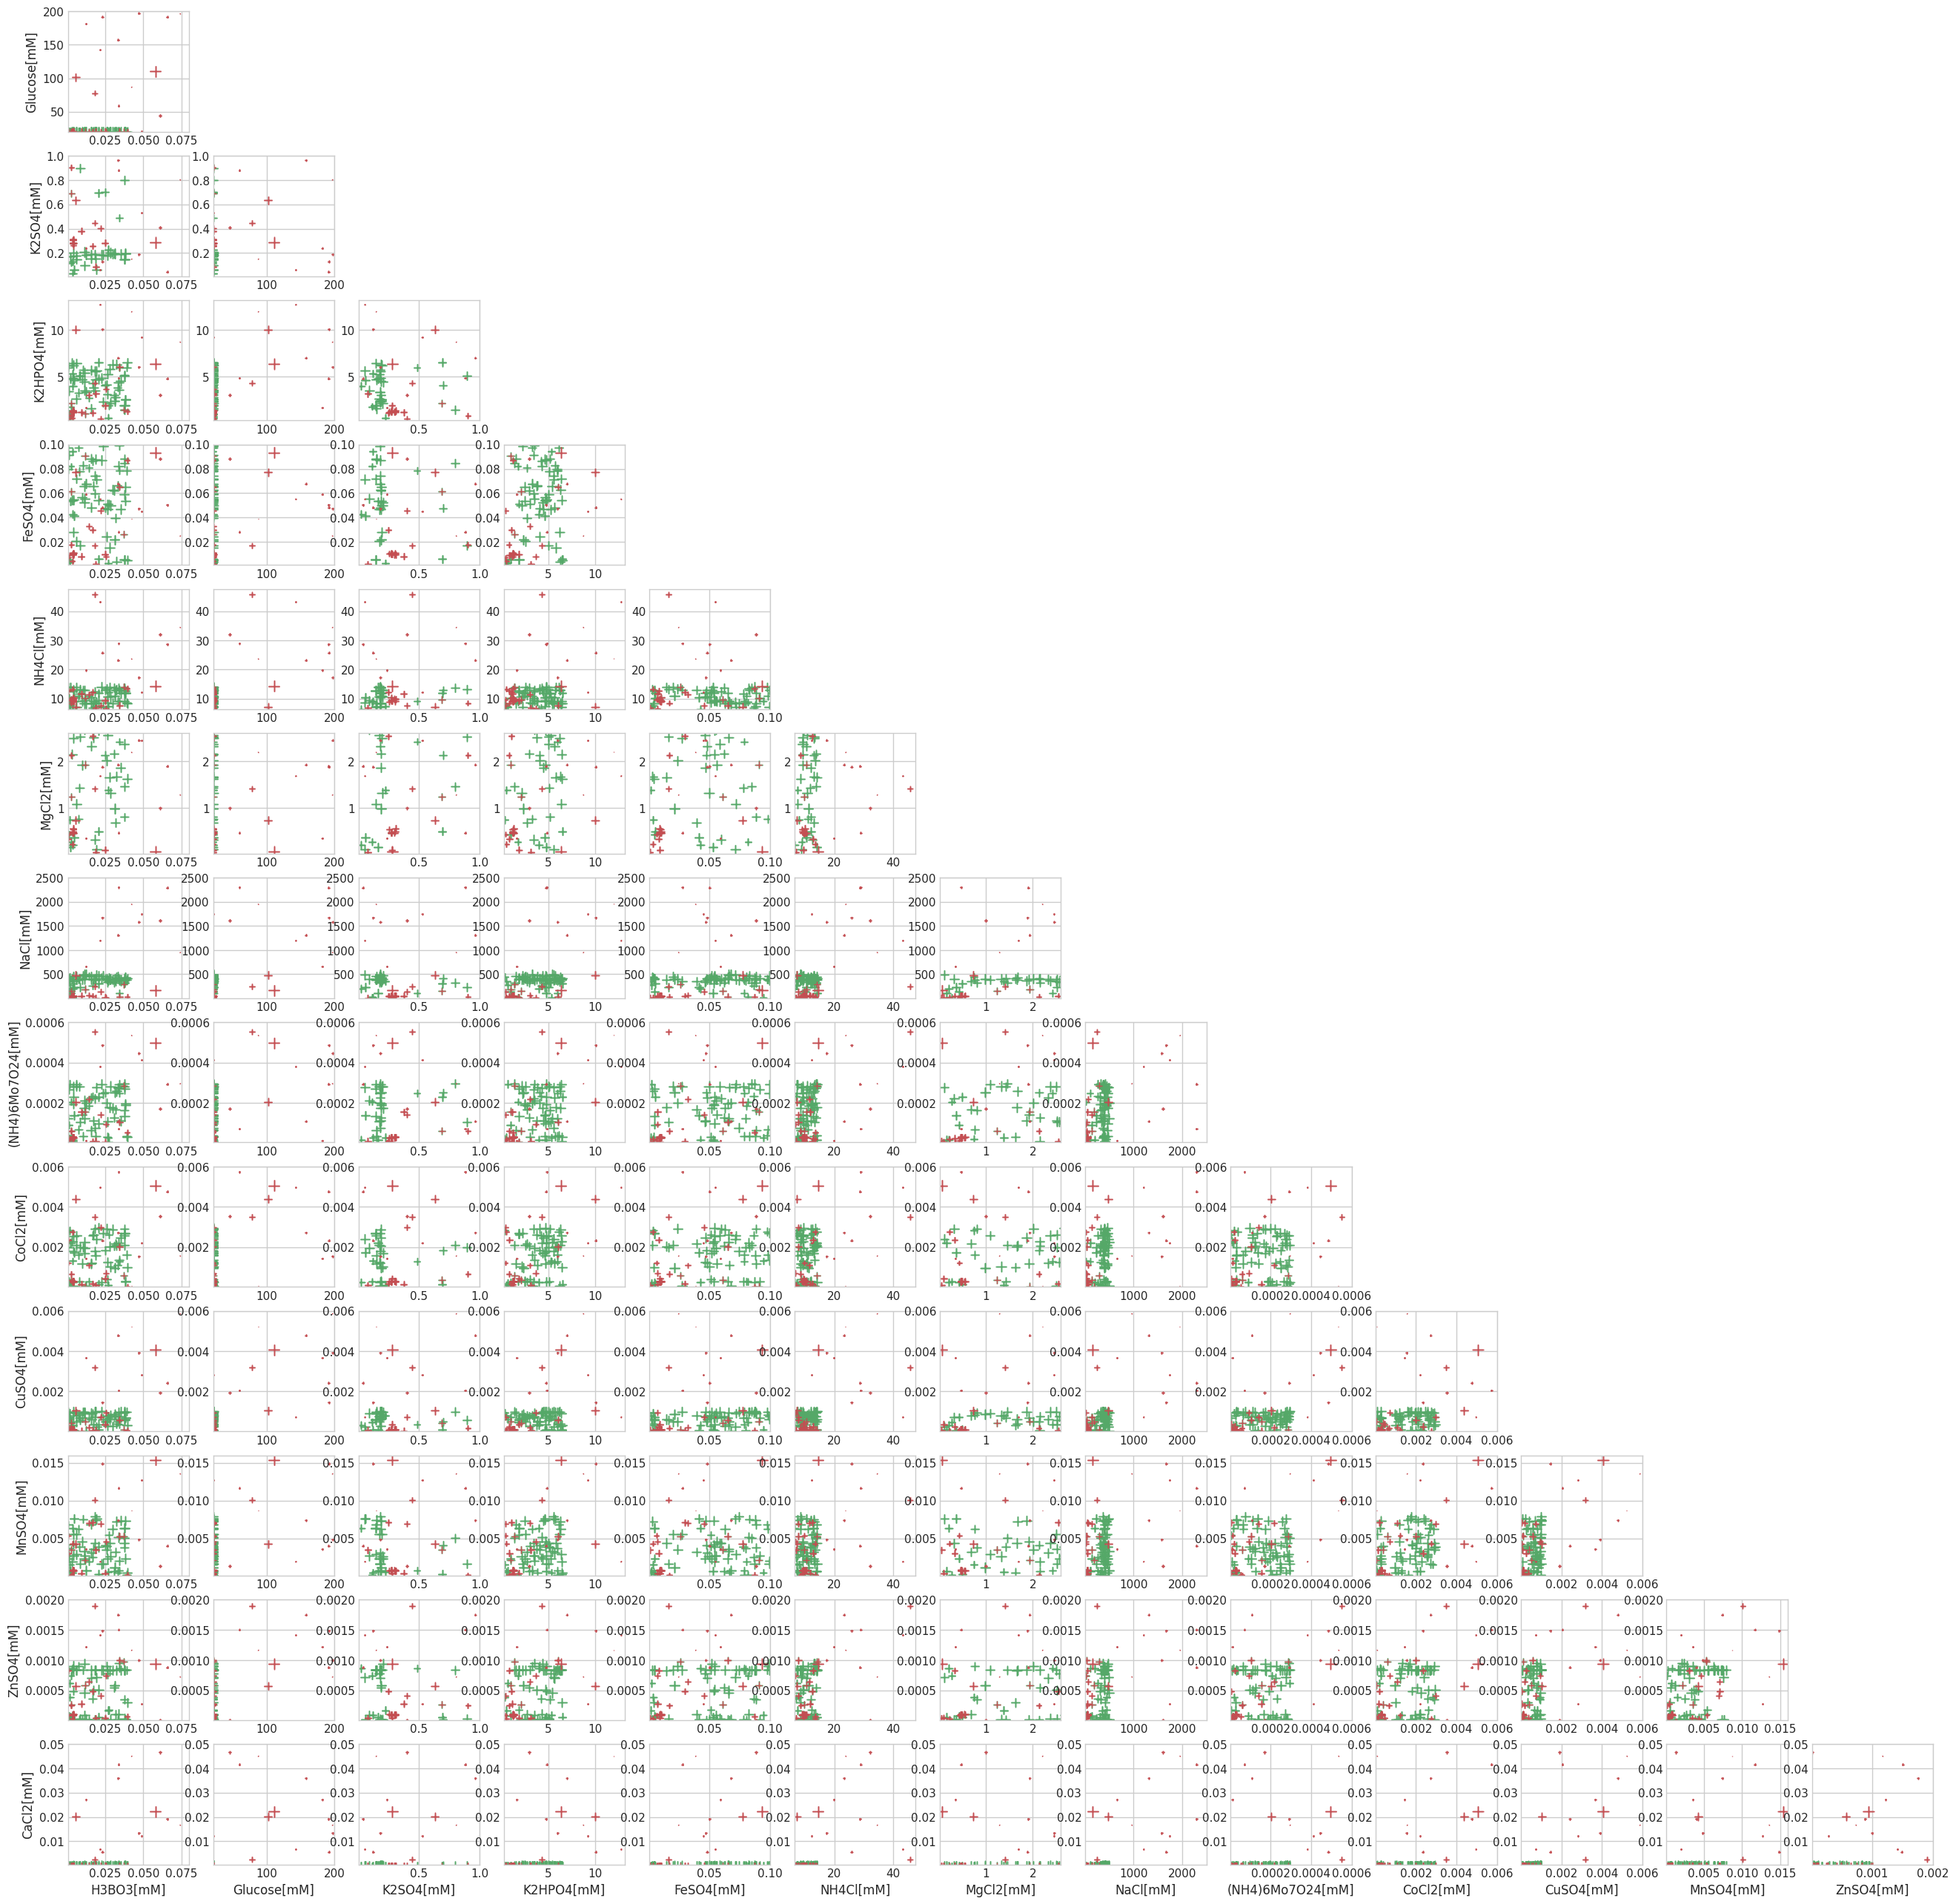

In [130]:
designs_pairwise(df_high, df_low, df_bounds)

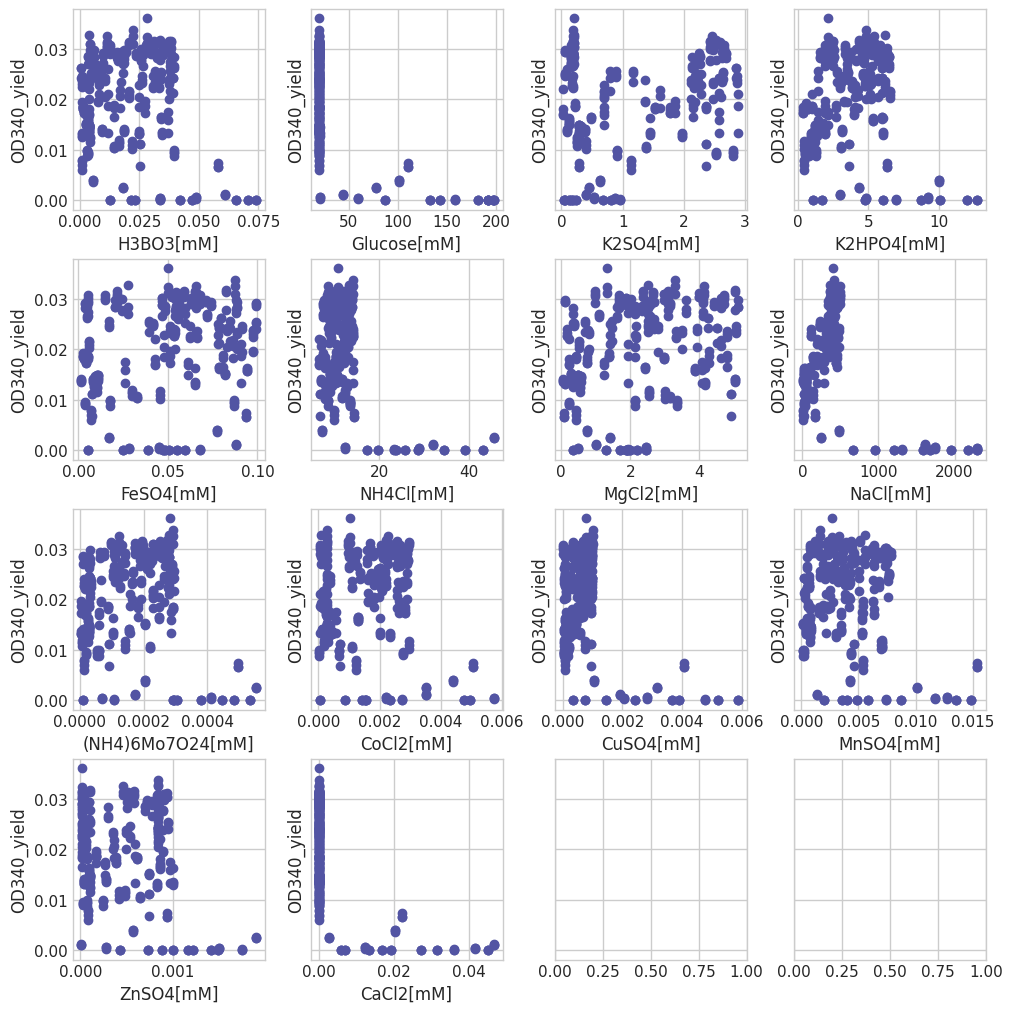

In [131]:
from matplotlib import cm
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10), sharey=True, constrained_layout=True)

cmap_name = 'tab20b'
colors = cm.get_cmap(cmap_name)

components = df_all.columns[:-2]

for component, ax in zip(components, axs.ravel()[:-2]):
    ax.scatter(
        df_all[component], 
        df_all['OD340_yield'], 
        color=colors(1), 
        marker='o', 
        )
    ax.set_xlabel(component)
    ax.set_ylabel('OD340_yield')
    
fig.savefig(
    f'{user_params["output_file_path"]}/Yield_per_component.png',
    bbox_inches="tight",
    transparent=False, 
    dpi=300
)